In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import glob
import cv2
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score
from keras import datasets, layers,  models
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, BatchNormalization, MaxPooling2D ,Dropout

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
images_dir = "/content/drive/MyDrive/Character_sets"
# list of all digits
digits = list(map(str, range(10))) + ["ba","cha","pa"]
# map digits to their respective directory path
digits_dir = dict(zip(digits, map(lambda d: os.path.join(images_dir, d), digits)))

In [4]:
digits, digits_dir

(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ba', 'cha', 'pa'],
 {'0': '/content/drive/MyDrive/Character_sets/0',
  '1': '/content/drive/MyDrive/Character_sets/1',
  '2': '/content/drive/MyDrive/Character_sets/2',
  '3': '/content/drive/MyDrive/Character_sets/3',
  '4': '/content/drive/MyDrive/Character_sets/4',
  '5': '/content/drive/MyDrive/Character_sets/5',
  '6': '/content/drive/MyDrive/Character_sets/6',
  '7': '/content/drive/MyDrive/Character_sets/7',
  '8': '/content/drive/MyDrive/Character_sets/8',
  '9': '/content/drive/MyDrive/Character_sets/9',
  'ba': '/content/drive/MyDrive/Character_sets/ba',
  'cha': '/content/drive/MyDrive/Character_sets/cha',
  'pa': '/content/drive/MyDrive/Character_sets/pa'})

In [5]:
# digits_col = []
# total_files_col = []
# for digit, folder in digits_dir.items():
#     total_files = len(glob.glob(os.path.join(folder, "*.jpg")))
#     digits_col.append(digit)
#     total_files_col.append(total_files)

# # prepare a pandas dataframe and sort by digit
# sample_count_df = pd.DataFrame({'count': total_files_col}, index=digits_col).sort_index()
# print(sample_count_df.describe())
# lower_percentile = sample_count_df.describe()['count']['25%']

# fix, axes = plt.subplots(1, 2, figsize=(12, 5))
# sample_count_df.plot.bar(ax=axes[0], title="Samples per digit")
# sample_count_df[sample_count_df['count'] < lower_percentile].plot.bar(ax=axes[1], title="Under Representend Sample"

In [6]:
total_images = sum(len(glob.glob(os.path.join(folder, "*.png"))) for _, folder in digits_dir.items())
total_images

10478

In [7]:
import keras.backend as K
validation_split = 0.3
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split,width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        images_dir,
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse',
        subset="training")

validation_generator = train_datagen.flow_from_directory(
       images_dir,
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse',
       subset="validation")

Found 10113 images belonging to 13 classes.
Found 4327 images belonging to 13 classes.


In [8]:
# # Metrics for checking the model performance while training
# def f1score(y, y_pred):
#   return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')

# def custom_f1score(y, y_pred):
#   return tf.py_function(f1score, (y, y_pred), tf.double)

In [9]:
from keras.layers import Input, Dense, BatchNormalization, MaxPooling2D ,Dropout, Conv2D ,Flatten
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=["accuracy"])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_accuracy')>0.995):
            print('\nReached 99.5% accuracy so cancelling training!')
            self.model.stop_training= True



In [12]:
batch_size = 64
callbacks = [myCallback()]
history=model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator,
      epochs = 50, verbose=1, callbacks=callbacks)

Epoch 1/50
158/158 [==============================] - 1093s 7s/step - loss: 3.2270 - accuracy: 0.1076 - val_loss: 2.8941 - val_accuracy: 0.1005
Epoch 2/50
158/158 [==============================] - 43s 271ms/step - loss: 2.7382 - accuracy: 0.1139 - val_loss: 2.6077 - val_accuracy: 0.0853
Epoch 3/50
158/158 [==============================] - 45s 282ms/step - loss: 2.5500 - accuracy: 0.1329 - val_loss: 2.3754 - val_accuracy: 0.1502
Epoch 4/50
158/158 [==============================] - 43s 271ms/step - loss: 2.4101 - accuracy: 0.1646 - val_loss: 2.2091 - val_accuracy: 0.2221
Epoch 5/50
158/158 [==============================] - 44s 278ms/step - loss: 2.1098 - accuracy: 0.3038 - val_loss: 1.9248 - val_accuracy: 0.3804
Epoch 6/50
158/158 [==============================] - 48s 302ms/step - loss: 2.0298 - accuracy: 0.3418 - val_loss: 1.8581 - val_accuracy: 0.3841
Epoch 7/50
158/158 [==============================] - 41s 261ms/step - loss: 1.7555 - accuracy: 0.4304 - val_loss: 1.5803 - val_acc

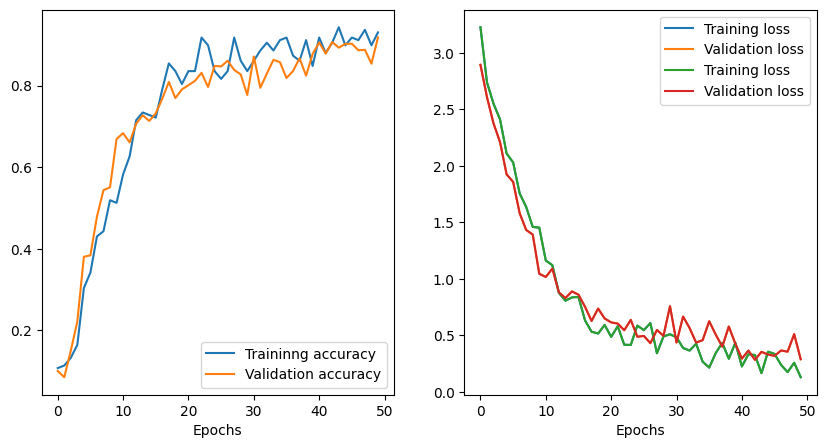

In [13]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(history.history['accuracy'], label='Traininng accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()


    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [14]:
X, Y_true = next(validation_generator)
Y_true = Y_true.argmax(axis=-1)
Y_pred = model.predict_on_batch(X).argmax(axis=-1)

In [16]:
# Save the model to the local disk
model.save('/content/model.h5')

In [17]:
from google.colab import files
files.download('/content/model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>